In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

2023-11-29 14:52:54.178479: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 14:52:54.178579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 14:52:54.178599: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 14:52:54.190956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


2023-11-29 14:53:50.451843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 14:53:50.766517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-29 14:53:50.766636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
def prepare_data(ds):
    
    ds = ds.map(lambda image, label: (tf.reshape(image,(-1,)),label))
    ds = ds.map(lambda image, label: ((tf.cast(image,tf.float32)/128)-1, label))
    ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth= 10)))
    ds = ds.shuffle(1024).batch(128)
    ds = ds.prefetch(32)

    return ds

2023-11-27 14:38:04.504180: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


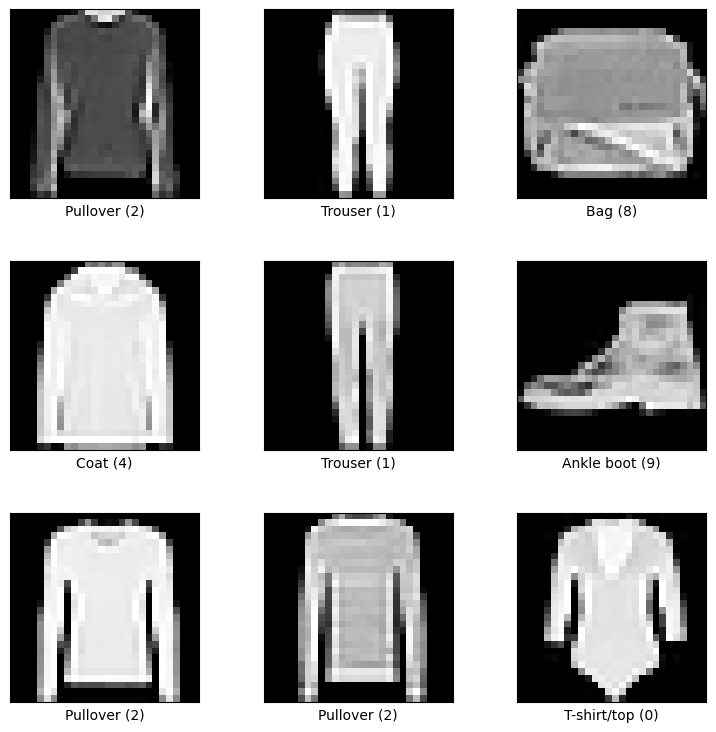

In [6]:
(train_ds, test_ds), ds_info = tfds.load('fashion_mnist', split=['train','test'], as_supervised=True, with_info=True)

tfds.show_examples(train_ds,ds_info)

train_ds = prepare_data(train_ds)
test_ds = prepare_data(test_ds)

In [ ]:
class FashionModel(tf.keras.Model):
    def __init__(self, layer_sizes, output_size=10):
        super().__init__()
        self.hiddenlayer = []
        for layer_size in layer_sizes:
            new_layer = tf.keras.layers.Dense(units = layer_size, activation='relu')
            self.hiddenlayer.append(new_layer)
        self.output_layer = tf.keras.layers.Dense(units = output_size, activation = 'softmax')

    @tf.function
    def call(self,x, training = True):
        for layer in self.hiddenlayer:
            x = layer(x)
        return self.output_layer(x)

In [ ]:
#use sequential 
def get_model_from_sequential(layer_sizes):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(784,), dtype=tf.float32))
    for ls in layer_sizes:
        model.add(tf.keras.layers.Dense(ls, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

def quick_get_model_from_sequential(layer_sizes):
    model = tf.keras.Sequential([tf.keras.layers.Dense(ls,activation='relu') for ls in layer_sizes] + tf.keras.layers.Dense(units = 10, activation = 'softmax'))


In [ ]:
#create network using functional API
def get_model_from_functional(layer_sizes,name):
    inputs = tf.keras.Input(shape=(784,), dtype=tf.float32) #never call it iput, because 'input' is an priviledged function! + Input type spezified is good for debuging
    x = inputs
    for ls in layer_sizes:
        x = tf.keras.layers.Dense(ls,activation='relu')(x)
    y = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.kreas.Model(input=inputs, outputs = y, name=name)
    return model
# + input
# + write call step from subclassing 
# + mistakes will be thrown early
# + easy and lazy, secure to write, readable
# - can gets unreadable
